# Set up environment
Let's load the basic modules and read the tables from disk

In [1]:
import numpy as np
import astropy.units as u
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

We will now load the two tables we generated in the last session. `data1` contains the Gaia query in a rectangle around our region of interest, excluding negative parallaxes. `cluster1` is our selection on the previous table to select sources with parallaxes between 5.0 and 5.7 mas.

⚠️ If you want to use the "official" `data1` and `cluster1` tables instead of the ones created by yourself do:
- open a terminal
- Navigate to the data folder  
`cd pysnacks_1/tutorials/data`
- Delete the files `data1.ecsv` and `cluster1.ecsv`.

In [2]:
import os
for my_file in ['data1', 'cluster1']:
    if not os.path.isfile(f'../data/{my_file}.ecsv'):
        print(f'Using official {my_file} file')
        os.system(f'unzip ../data/backup/{my_file}.ecsv.zip')
        os.system(f'mv {my_file}.ecsv ../data')
    else:
        print(f'Doing nothing because ../data/{my_file}.ecsv already exists')

Doing nothing because ../data/data1.ecsv already exists
Doing nothing because ../data/cluster1.ecsv already exists


In [3]:
data1 = Table.read('../data/data1.ecsv')
cluster1 = Table.read('../data/cluster1.ecsv')

# ADQL searches

Astronomical Data Query Language (ADQL) is a language developed for astronomy to query catalogs and tables following Virtual Observatory standards. Full specifications can be found [here](https://www.ivoa.net/documents/ADQL/20180112/PR-ADQL-2.1-20180112.html).

- Other resources are this [ADQL Cheat Sheet](http://simbad.u-strasbg.fr/simbad/tap/help/adqlHelp.html)
- Many ADQL examples on Gaia data: https://gaia.ari.uni-heidelberg.de/tap.html

In [4]:
from astroquery.gaia import Gaia

Gaia provides a large amount of tables. If you want to see all available tables (including many cross-matches with other catalogs like SDSS, WISE, UCAC4, Hipparcos, etc) you can run:
```python
tables = Gaia.load_tables(only_names=True)
for table in tables:
    print(table.name)
```

For this tutorial we are going to use table the full Gaia EDR3 catalog: `gaiaedr3.gaia_source`.

## Basic ADQL query

There are 4 main stages for a query:
1. Write the query as a text string
2. Launch the job with the function `Gaia.launch_job()`
3. Convert the job into an astropy Table with `job.get_results()`.

The query will be written as a python string, which will then be send to a job to actually conduct the query on the Gaia server. The main ingredients to write a query are these statements.
- `SELECT`: this statement is used to select data from a database.
- `TOP`: to limit the query to a certain number of rows. `*` would download all the rows, be careful!
- `FROM`: to indicate the table we want to query.
- `WHERE`: to include a filter to select specific data. `AND` to include additional filters.

Although it is not a formal requirement, these statements are usually included in CAPITAL letters, while our values are written in lowercase.

In [5]:
query1 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax
FROM
    gaiaedr3.gaia_source
"""

Note that dividing in lines and adding spaces is just to make it nice. The query could be written as:
```python
query1 = "SELECT TOP 10 ra, dec, pmra, pmdec, parallax FROM gaiaedr3.gaia_source"
```

In [6]:
job1 = Gaia.launch_job(query1)   # Here is where the data are downloaded!

In [7]:
table1 = job1.get_results()

In [8]:
table1

ra,dec,pmra,pmdec,parallax
deg,deg,mas / yr,mas / yr,mas
float64,float64,float64,float64,float64
110.12697777606687,-10.909676874540123,0.3546613603523684,-0.824888188231624,0.6092313141566454
110.13374594116718,-10.910447523777394,-0.730788257162717,0.7557675234132424,0.35898551001251433
110.12512421546889,-10.906964380852706,--,--,--
110.12459390284779,-10.906773074364983,-1.6591241215256036,1.9429692007637769,1.5085325623843142
110.13289698316765,-10.913584596673912,-0.920433758469247,0.3007427881620029,0.3312456738710822
110.12845895060636,-10.912934834542051,-5.105061045217545,2.1750639876395406,1.1873844690430397
110.13098362260791,-10.915409228095706,-0.44248048226432873,0.15906889548483363,0.19076492083075972
110.12451111253554,-10.916928157139322,--,--,--


Now let's add a filter. This will be filtered in the input catalog, so it is fast

In [9]:
query2 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax
FROM
    gaiaedr3.gaia_source
WHERE
    parallax > 250
"""
job2 = Gaia.launch_job(query2)
table2 = job2.get_results()
table2

ra,dec,pmra,pmdec,parallax
deg,deg,mas / yr,mas / yr,mas
float64,float64,float64,float64,float64
319.2950181380955,-38.872456400701786,-3258.966218702396,-1145.8623969124255,251.9124222107058
77.9599373502188,-45.0438126993602,6491.223339061598,-5708.614150045243,254.19859326384577
43.26964247679057,16.86437381897744,3429.0828268077694,-3805.54112273733,260.98844068047276
111.85462844259372,5.209382701706996,571.2323467293181,-3691.4865653792745,264.12689775460655
18.13325425370941,-16.996154872479234,1205.074450317742,637.5466339679103,269.05730465038937
331.07645259656397,-56.79381206688221,3981.97666296105,-2466.8318147663504,270.6580324694526
54.00339387736301,-44.51436231604776,745.6543400042402,-373.3232809136534,272.16154083178225
26.009055057160104,-15.933680200693857,-1721.7277944720731,854.9631570589582,273.80974511859966


And adding additional filters is also easy:


In [10]:
query3 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source
WHERE
    parallax > 10
    AND dec BETWEEN 55 AND 60
    AND pmra > 100
"""
job3 = Gaia.launch_job(query3)
table3 = job3.get_results()
table3

ra,dec,pmra,pmdec,parallax,phot_g_mean_mag
deg,deg,mas / yr,mas / yr,mas,mag
float64,float64,float64,float64,float64,float32
39.55534450841904,55.70117410383229,133.8178117295073,-11.837413755695902,19.11510100168238,11.550609
73.001541835844,57.82064962211621,174.67043502513522,-173.62505448473277,16.17298230381911,16.471771
67.93424053887837,56.49415175469436,156.26681909748066,-203.33919856668535,15.3333870648532,17.843945
70.52203182388584,57.218527577845585,121.71501407431862,-17.931875936951727,13.118525159179592,14.149204
67.77970024894226,57.14174772278866,117.29933997974308,-10.000585324838873,30.862572147591337,9.700968
67.56932178379238,57.403814933033615,122.11089841693095,-98.56116554188154,11.743476351018504,11.513459
68.21080482528,56.52847940299108,349.04936080414313,-299.0663710676119,29.272908092568912,15.477264
69.03014271319383,55.410901812317256,543.9124159491503,-302.82400193311247,30.09392297788444,8.076589


### ⛏ Exercise 3.1
Construct and run a query named `job3_1` using the following information:
- Select 10 rows.
- Query table `gaiaedr3.gaia_source`.
- Select columns: right ascension, declination and phot_g_mean_mag.
- Use filters to select stars with dec between 50 and 80 deg and magnitude brighter than 10

In [11]:
query3_1 = """
SELECT
TOP 10
    ra, dec, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source
WHERE
    dec BETWEEN 50 AND 80
    AND phot_g_mean_mag < 10
"""
job3_1 = Gaia.launch_job(query3_1)
table3_1 = job3_1.get_results()
table3_1

ra,dec,phot_g_mean_mag
deg,deg,mag
float64,float64,float32
193.50817846782095,55.959784778923755,1.731607
10.12724197930297,56.53718879378639,1.9425238
14.177450998208093,60.71672280471204,2.0645833
2.2990654282325518,59.14897576410493,2.232691
200.98237336533253,54.92525907860076,2.282647
165.46097417209683,56.38257749355825,2.3985364
319.64633694354825,62.58579604829105,2.428267
178.45836676657404,53.694797326318046,2.4362755


How to know which columns are available?

In [12]:
table_metadata = Gaia.load_table('gaiaedr3.gaia_source')
for column in table_metadata.columns:
    print(f"{column.name:30}: {column.description}")

Retrieving table 'gaiaedr3.gaia_source'
solution_id                   : Solution Identifier
designation                   : Unique source designation (unique across all Data Releases)
source_id                     : Unique source identifier (unique within a particular Data Release)
random_index                  : Random index used to select subsets
ref_epoch                     : Reference epoch
ra                            : Right ascension
ra_error                      : Standard error of right ascension
dec                           : Declination
dec_error                     : Standard error of declination
parallax                      : Parallax
parallax_error                : Standard error of parallax
parallax_over_error           : Parallax divided by its standard error
pm                            : Total proper motion
pmra                          : Proper motion in right ascension direction
pmra_error                    : Standard error of proper motion in right ascension 

We can rename columns and give a name to the table.

In [13]:
query4 = """
SELECT
TOP 10
    ra AS right_ascension, dec AS declination, pmra, pmdec, parallax AS plx, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 10
    AND dec > 60
    AND pmra > 100
"""
job4 = Gaia.launch_job(query4)
table4 = job4.get_results()
table4

right_ascension,declination,pmra,pmdec,plx,phot_g_mean_mag
deg,deg,mas / yr,mas / yr,mas,mag
float64,float64,float64,float64,float64,float32
124.01144966021175,65.88461692187626,169.84974708266532,-24.570410918912756,18.038639548679384,20.91073
120.43804827470753,68.86202269142112,133.63583347344328,3.3750313610693956,13.72848737126279,16.861578
129.4503472979296,64.71585025054333,120.78641610564706,34.47326771205426,11.339471660941864,9.413093
119.20575805974968,66.83225418999076,161.93030391025002,-212.18945951987138,23.49525243858702,17.78913
118.08689347243653,69.42490496669896,127.26088845038271,-184.6974457158127,14.080704792233242,16.69432
118.08533569980663,69.42563479208752,126.22933243851233,-184.62388991566053,14.056114013587498,14.970832
122.58738707958943,69.72560126912373,162.99237948955613,116.76920053112454,33.463540006349675,6.4029765
127.48968033210458,61.72258164768267,530.7950990781364,-715.2782846089408,49.288752987563555,9.659495


We can create new columns as combinations of other ones including complex operations.


In [14]:
query5 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, pmra_error, pmdec_error,
    sqrt(power(pmra_error, 2) + power(pmdec_error, 2)) AS pm_error
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 10
    AND dec > 60
    AND pmra > 100
    AND sqrt(power(pmra_error, 2) + power(pmdec_error, 2)) < 0.1
"""
job5 = Gaia.launch_job(query5)
table5 = job5.get_results()
table5

ra,dec,pmra,pmdec,pmra_error,pmdec_error,pm_error
deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,
float64,float64,float64,float64,float32,float32,float64
120.43804827470753,68.86202269142112,133.63583347344328,3.3750313610693956,0.041086283,0.055974327,0.06943491846720999
129.4503472979296,64.71585025054333,120.78641610564706,34.47326771205426,0.025411397,0.038386714,0.04603562640305742
118.08689347243653,69.42490496669896,127.26088845038271,-184.6974457158127,0.0427494,0.05347884,0.06846530295085035
118.08533569980663,69.42563479208752,126.22933243851233,-184.62388991566053,0.016621985,0.021808855,0.02742109656416782
127.48968033210458,61.72258164768267,530.7950990781364,-715.2782846089408,0.013492958,0.013408528,0.01902231643441946
126.49040353037444,66.16833582259768,144.786785712217,124.37529053547584,0.030179866,0.04561104,0.05469178322140326
124.59358012860116,61.46085607940323,128.26588482263713,30.42697419536343,0.017638555,0.018331049,0.025439063919976128
107.0934699216425,60.894279372999705,374.403109862856,-347.5239300167945,0.021102061,0.019266477,0.028574361405612567


This means we can directly compute the distance in kpc as 1/parallax[mas]. Note: you cannot call the column "distance" because that is a reserved ADQL statement.

In [15]:
query6 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, 1/parallax AS distance_kpc
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 1
    AND dec > 60
    AND pmra > 100
"""
job6 = Gaia.launch_job(query6)
table6 = job6.get_results()
table6

ra,dec,pmra,pmdec,parallax,distance_kpc
deg,deg,mas / yr,mas / yr,mas,
float64,float64,float64,float64,float64,float64
74.66451270361384,62.15181340608831,100.00193154067665,-88.86589952933775,12.505373845741055,0.07996562216655116
149.41600324144636,67.49217956894574,100.00879826225145,-69.8566220872247,10.091146997935779,0.09909676275695495
139.97476242532935,66.05549888164397,100.0095895872081,-69.62102585379789,15.98423787439987,0.06256163151835883
323.84691274648014,67.52300451606419,100.02507110926138,-6.417828960232144,19.497322234874673,0.051289094366574584
8.774216010678863,66.09847004748724,100.02592661671935,77.55322853028491,4.880189684813282,0.20491006796557754
50.912557004283634,73.96366867624116,100.0261031618998,-94.51463946438408,5.764660649771974,0.17347074888780414
21.723091909676675,69.29224228578344,100.04218136198642,-30.740662923862253,4.436027695340312,0.2254269063852823
6.876645499764789,71.20594200585153,100.04921965493844,2.8273362498455668,3.0536148859229333,0.3274807195268689


For example, we can directly compute the absolute magnitude and create a new column:

In [16]:
query7 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, phot_g_mean_mag,
    gaia.phot_g_mean_mag + 5*log10(gaia.parallax) - 10 AS g_mag_abs
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    parallax > 10
    AND dec > 60
    AND pmra > 100
"""
job7 = Gaia.launch_job(query7)
table7 = job7.get_results()
table7

ra,dec,pmra,pmdec,parallax,phot_g_mean_mag,g_mag_abs
deg,deg,mas / yr,mas / yr,mas,mag,
float64,float64,float64,float64,float64,float32,float64
124.01144966021175,65.88461692187626,169.84974708266532,-24.570410918912756,18.038639548679384,20.91073,17.19174926444787
120.43804827470753,68.86202269142112,133.63583347344328,3.3750313610693956,13.72848737126279,16.861578,12.54969143040855
129.4503472979296,64.71585025054333,120.78641610564706,34.47326771205426,11.339471660941864,9.413093,4.686056713128586
119.20575805974968,66.83225418999076,161.93030391025002,-212.18945951987138,23.49525243858702,17.78913,14.64402983493899
118.08689347243653,69.42490496669896,127.26088845038271,-184.6974457158127,14.080704792233242,16.69432,12.437442645822813
118.08533569980663,69.42563479208752,126.22933243851233,-184.62388991566053,14.056114013587498,14.970832,10.710158227040015
122.58738707958943,69.72560126912373,162.99237948955613,116.76920053112454,33.463540006349675,6.4029765,4.025835921668726
127.48968033210458,61.72258164768267,530.7950990781364,-715.2782846089408,49.288752987563555,9.659495,8.123234506607584


## Select by region

In [17]:
query8 = """
SELECT
TOP 10
    ra, dec, pmra, pmdec, parallax, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    CONTAINS(POINT(ra, dec), CIRCLE(15, 60, 0.1)) = 1
"""
job8 = Gaia.launch_job(query8)
table8 = job8.get_results()
table8

ra,dec,pmra,pmdec,parallax,phot_g_mean_mag
deg,deg,mas / yr,mas / yr,mas,mag
float64,float64,float64,float64,float64,float32
15.071831169789679,59.91302873540859,--,--,--,20.977959
14.933407749253156,59.91153362051373,5.3847781088986935,-1.9325072661079779,-0.30453374880917633,20.50302
14.937958587597747,59.90932563471064,-3.1696274429712084,-1.4072159490972487,0.10879996568743136,18.139885
14.937548388938223,59.90891303230689,-0.7745266496067702,-0.9903480716602326,-0.561817412847953,20.46902
14.939829641766513,59.90624967964418,-2.4632653146799894,-1.2223383927227272,0.1753889214442334,18.504358
14.94113722990093,59.90615950498211,-1.9887068693401864,-1.4055849953931179,-0.3320124881313277,19.67224
14.936752386111156,59.90689111014183,--,--,--,20.935993
14.934914803073248,59.90953548064737,--,--,--,20.938787


## Create a query programatically

In [18]:
my_columns = 'ra, dec, phot_g_mean_mag'
my_table = 'gaiaedr3.gaia_source'
min_dec = 50
max_dec = 80
max_mag = 10

In [50]:
query9 = f"""
SELECT
TOP 10
    {my_columns}
FROM
    {my_table}
WHERE
    dec BETWEEN {min_dec} AND {max_dec}
    AND phot_g_mean_mag < {max_mag}
"""
print(query9)


SELECT
TOP 10
    ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, astrometric_matched_transits, phot_g_mean_flux, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, bp_g, g_rp, dr2_radial_velocity, dr2_radial_velocity_error, dr2_rv_template_teff
FROM
    gaiaedr3.gaia_source
WHERE
    dec BETWEEN 18.98333 AND 20.98333
    AND phot_g_mean_mag < 10



In [51]:
job9 = Gaia.launch_job(query9)
table9 = job9.get_results()
table9

ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_matched_transits,phot_g_mean_flux,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_template_teff
deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,electron / s,mag,mag,mag,mag,mag,mag,km / s,km / s,K
float64,float64,float64,float32,float64,float32,float64,float32,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32
168.52777245409249,20.523137041266512,--,--,--,--,--,--,6,1763169653.9569733,2.5716317,3.1165872,2.551048,0.5655391,0.5449555,0.02058363,--,--,--
299.6895907690142,19.4922471120651,11.337545204585858,0.16515924,65.00494835300688,0.15167242,22.72079936785127,0.15175164,36,1352700348.1326594,2.8593628,3.947543,2.2505422,1.6970007,1.0881801,0.6088207,--,--,--
67.15467370962931,19.180273317307044,22.36535445562801,0.1721149,107.5257715587816,0.1931528,-36.20007001971977,0.12613854,35,917836761.8538833,3.2804532,3.898934,2.6619565,1.2369773,0.6184807,0.61849666,--,--,--
106.02717676046669,20.570294274158407,3.0729129856354085,0.2177457,-7.738172506163677,0.2511777,-0.9432405550932031,0.16647035,14,723005161.9439583,3.5395133,3.973537,2.9866095,0.9869275,0.43402362,0.5529039,10.368093,13.058811,5500.0
245.47983846631206,19.153320268640844,16.86704837454732,0.14138384,-47.2832107122308,0.11317892,43.13888981594056,0.1157522,50,628417012.6806391,3.691747,3.845034,3.4043772,0.44065666,0.15328693,0.28736973,--,--,--
320.52216241512485,19.804789713946604,20.848168338475414,0.14524819,105.39116798282723,0.15698768,62.84054757968135,0.08982463,36,583637197.0746934,3.7720094,4.3642673,3.0705426,1.2937248,0.592258,0.7014668,-77.825226,1.4657072,4750.0
3.651119417436693,20.206708004381166,9.405199843331518,0.16729675,91.8314169240906,0.18704014,1.1522613909421215,0.17407155,44,480017869.54155207,3.9842234,5.0513515,2.985399,2.0659525,1.0671282,0.99882436,--,--,--
97.24075374613999,20.212076430854843,4.447477074560435,0.44097963,-4.669146333913291,0.42401078,-14.40180549838631,0.33081618,12,448083784.5939597,4.058969,4.060721,4.1768317,-0.1161108,0.0017518997,-0.1178627,--,--,--


You can verify that `query9` is exactly the same as `query3_1` and the `table9` is the same as `table3_1`.

In [52]:
print(query9, query3_1)


SELECT
TOP 10
    ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, astrometric_matched_transits, phot_g_mean_flux, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, bp_g, g_rp, dr2_radial_velocity, dr2_radial_velocity_error, dr2_rv_template_teff
FROM
    gaiaedr3.gaia_source
WHERE
    dec BETWEEN 18.98333 AND 20.98333
    AND phot_g_mean_mag < 10
 
SELECT
TOP 10
    ra, dec, phot_g_mean_mag
FROM
    gaiaedr3.gaia_source
WHERE
    dec BETWEEN 50 AND 80
    AND phot_g_mean_mag < 10



In [53]:
print(table9)
print(table3_1)

        ra                dec         ... dr2_rv_template_teff
       deg                deg         ...          K          
------------------ ------------------ ... --------------------
168.52777245409249 20.523137041266512 ...                   --
 299.6895907690142   19.4922471120651 ...                   --
 67.15467370962931 19.180273317307044 ...                   --
106.02717676046669 20.570294274158407 ...               5500.0
245.47983846631206 19.153320268640844 ...                   --
320.52216241512485 19.804789713946604 ...               4750.0
 3.651119417436693 20.206708004381166 ...                   --
 97.24075374613999 20.212076430854843 ...                   --
 47.90808720855174 19.726648284350475 ...               4750.0
 281.4154805359527 20.544817390173186 ...               6500.0
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
193.50817846782095 

### ⛏ Exercise 3.2

- Use `SkyCoord.from_name()` to get the coordinates of the star Vega.
- Run an ADQL query to find stars within 50 arcsec of that position to obtain columns 'ra, dec, phot_g_mean_mag, distance_kpc'. You will need to compute the new column distance_kpc.
- Is Vega included in the resulting table? Read more [I can not find data for a bright star. Why is that?](https://www.cosmos.esa.int/web/gaia/faqs#BrightStar). Also, read about the VEGAMAG system [here](https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_calibr_extern.html#SSS6):
> The VEGAMAG system is defined so that Vega’s colours are all zero: this is equivalent to normalizing all the observed fluxes to the flux of Vega.

In [22]:
vega_coord = SkyCoord.from_name("Vega")
vega_coord.to_string('hmsdms')
search_radius = 50/60/60 # We need in degrees

In [ ]:
query3_2 = f"""
SELECT
TOP 1000
    ra, dec, phot_g_mean_mag, 1/parallax AS distance_kpc
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    CONTAINS(POINT(ra, dec),
    CIRCLE({vega_coord.ra.deg}, {vega_coord.dec.deg}, {search_radius})) = 1
"""
print(query3_2)

job3_2 = Gaia.launch_job(query3_2)
table3_2 = job3_2.get_results()
table3_2

ra,dec,phot_g_mean_mag,distance_kpc
deg,deg,mag,
float64,float64,float32,float64
279.23090140207887,38.77493571907557,16.828749,1.6757087299450542
279.24601139325796,38.77404619176373,17.17283,-0.5162007040686745
279.24289761454577,38.78910887473515,17.335606,--
279.2222641579334,38.774730984228476,16.93353,0.26777310537663623
279.2242956202031,38.78935247026724,15.78001,1.4851713119866699


### 🌪 Additional fun
Repeat the query around Vega but with a radius of 100 arcsec. Select 50 rows. Make a plot of the R.A. and Dec. of the resulting stars.

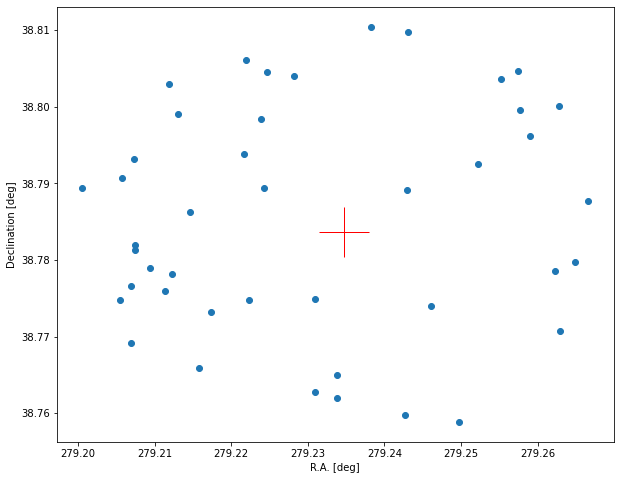

In [39]:
vega_coord = SkyCoord.from_name("Vega")
vega_coord.to_string('hmsdms')
search_radius = 100/60/60 # We need in degrees
query3_2b = f"""
SELECT
TOP 50
    ra, dec, phot_g_mean_mag, 1/parallax AS distance_kpc
FROM
    gaiaedr3.gaia_source AS gaia
WHERE
    CONTAINS(POINT(ra, dec),
    CIRCLE({vega_coord.ra.deg}, {vega_coord.dec.deg}, {search_radius})) = 1
"""
job3_2b = Gaia.launch_job(query3_2b)
table3_2b = job3_2b.get_results()
table3_2b

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(table3_2b['ra'], table3_2b['dec'], 'o')
ax.plot(vega_coord.ra.deg, vega_coord.dec.deg, '+', color='r', ms=50)

ax.set_aspect('equal')

ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Declination [deg]');

## Query the region of interest around our star cluster
Now we will repeat the search we did in sessions 1 and 2: all Gaia stars in a rectangle of 3 deg x 2 deg centred at R.A. 130.025 deg and Dec. 19.98333 deg. Then, we created `data1` selecting only positive parallaxes and we added the distance and absolute magnetiude columns. We will do all steps in a single go with ADQL.

In [26]:
my_table = 'gaiaedr3.gaia_source'
min_ra = 130.025 - 3/2
max_ra = 130.025 + 3/2
min_dec = 19.98333 - 2/2
max_dec = 19.98333 + 2/2
min_parallax = 0

In [54]:
# We defined gaia_columns as a python list in tutorial 1. Here we need a single string
gaia_columns = ['ra','dec','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_matched_transits','phot_g_mean_flux','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','bp_g','g_rp','dr2_radial_velocity','dr2_radial_velocity_error','dr2_rv_template_teff']
my_columns = ', '.join(gaia_columns)  # This creates a comma-separated string from a list
my_columns

'ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, astrometric_matched_transits, phot_g_mean_flux, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, bp_g, g_rp, dr2_radial_velocity, dr2_radial_velocity_error, dr2_rv_template_teff'

Apart from `my_columns` we will create two new columns: `distance_kpc` and `g_mag_abs`.

In [55]:
query_final = f"""
SELECT
TOP 35000
    {my_columns},
    1/parallax AS distance_kpc,
    phot_g_mean_mag + 5*log10(parallax) - 10 AS g_mag_abs
FROM
    {my_table}
WHERE
    ra BETWEEN {min_ra} AND {max_ra}
    AND dec BETWEEN {min_dec} AND {max_dec}
    AND parallax > {min_parallax}
"""
print(query_final)


SELECT
TOP 35000
    ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, astrometric_matched_transits, phot_g_mean_flux, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, bp_g, g_rp, dr2_radial_velocity, dr2_radial_velocity_error, dr2_rv_template_teff,
    1/parallax AS distance_kpc,
    phot_g_mean_mag + 5*log10(parallax) - 10 AS g_mag_abs
FROM
    gaiaedr3.gaia_source
WHERE
    ra BETWEEN 128.525 AND 131.525
    AND dec BETWEEN 18.98333 AND 20.98333
    AND parallax > 0



In [56]:
job_final = Gaia.launch_job(query_final)
data1_adql = job_final.get_results()

In [57]:
data1_adql

ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_matched_transits,phot_g_mean_flux,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_template_teff,distance_kpc,g_mag_abs
deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,electron / s,mag,mag,mag,mag,mag,mag,km / s,km / s,K,,
float64,float64,float64,float32,float64,float32,float64,float32,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
131.22968270095606,18.983827201863143,0.31998871956721814,0.49794808,-1.6223404085587294,0.5614138,-1.0105924563161917,0.38008142,46,241.0244269476377,19.732214,20.053925,19.384422,0.66950226,0.3217106,0.34779167,--,--,--,3.1251101643598282,7.257887316910093
131.28445136091062,19.00845193710329,0.5151998785794699,1.3006121,-1.5297876468186185,1.2919384,-2.843560646665468,1.2246985,25,96.2696925676696,20.728643,20.89959,20.31875,0.58083916,0.17094612,0.40989304,--,--,--,1.9409942462665961,9.28852217735211
131.28563865066036,19.010494922567894,0.13490804016686328,0.3181554,-3.076730055168175,0.3238071,-7.359471668488383,0.23946682,47,394.8387851857072,19.196318,19.62897,18.777939,0.85103035,0.43265152,0.41837883,--,--,--,7.412456653903898,4.846506839030049
131.25698350902147,18.99538731950092,1.2187092847745848,0.2575996,-5.5986482301070515,0.25462997,-4.4498040876448846,0.19418992,45,575.2274112416579,18.787767,19.775286,17.816483,1.9588032,0.9875183,0.97128487,--,--,--,0.8205402325994112,9.217268009429358
131.2355391791492,18.999266470059794,0.5964944744112647,0.69358546,-9.987451244118489,0.6922935,1.4050607195805065,0.5469776,44,166.8080069396004,20.131824,20.92843,18.943783,1.9846478,0.79660606,1.1880417,--,--,--,1.6764614642692073,9.00985661823622
131.23663846952257,19.000781690200437,0.8711013589326823,0.073754616,-10.281595584933397,0.07906608,1.6545907275451583,0.06229423,45,4077.3282298584913,16.661428,17.27445,15.9210205,1.3534298,0.61302185,0.74040794,--,--,--,1.147972035338403,6.361771907770752
131.27836980626788,19.01688286266123,1.11703994851533,0.01790161,2.057040558069246,0.018296564,1.50343545327416,0.014275822,46,77931.8217543654,13.458079,13.736864,13.01631,0.72055435,0.27878475,0.4417696,--,--,--,0.8952231308549985,3.69842286304986
131.27870091778294,19.020709260033875,4.794118754888754,0.043951128,15.603651580360394,0.045697227,-41.20474724407915,0.034721203,48,9327.298367502075,15.762978,16.970934,14.671906,2.2990274,1.2079563,1.0910711,--,--,--,0.20858890885426234,9.166521538692322


Are the table obtained with ADQL exactly the same as the one obtained with astroquery and modified as a table? Let's see if the number of entries and some average values match exacty.

In [58]:
print(len(data1),               len(data1_adql))                   # The number of entries
print(data1['ra'].mean(),       data1_adql['ra'].mean())           # Same mean R.A.?
print(data1['parallax'].mean(), data1_adql['parallax'].mean())     # Same mean parallax?
print(data1['distance'].mean(), data1_adql['distance_kpc'].mean()) # Same mean computed distance?
print(data1['Mg'].mean(),       data1_adql['g_mag_abs'].mean())    # Same mean computed absolute magnitude?
print('Yes!')

23050 23050
129.99954593828224 129.99954593828224
1.2586897281600946 1.2586897281600946
3.644157839486788 3.6441578394867884
7.521207604826898 7.521207604826898
Yes!


# Advanced plotting with multiple panels

For this section we have two main objectives:
- Describe how to manage plots with multiple panels.
- Write functions to simplify the plot management.

## Multiple subplots in a single figure

You can use  
`fig, ax = plt.subplots(ncols=XX, nrows=YY, figsize=(18,6))`  
to create XX times YY panels in a single plot, Now `ax` will be an array of size (XX, YY).

Here are some example of how `ax` looks like when creating multiple panels:

- When you use ncols=2, nrows=1:
  - `ax[0]` left panel
  - `ax[1]` right panel

- When you use ncols=1, nrows=2:
  - `ax[0]` top panel
  - `ax[1]` bottom panel
  
- When you use ncols=2, nrows=3:
  - `ax[0, 0]` top    left  panel
  - `ax[1, 0]` middle left  panel
  - `ax[2, 0]` bottom left  panel
  - `ax[0, 1]` top    right panel
  - `ax[1, 1]` middle right panel
  - `ax[2, 1]` bottom right panel

Show the general nomenclature is [row, column]

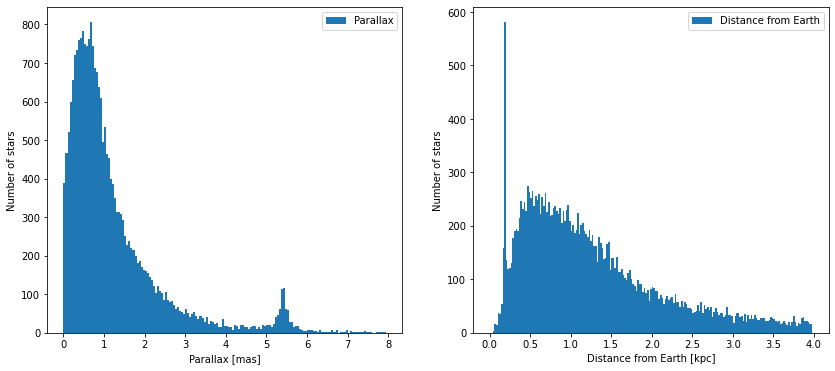

In [136]:
col1 = 'parallax'
col2 = 'distance'

fig, ax = plt.subplots(ncols=2, figsize=(14,6))# We can select ncols, nrows, or both.

ax[0].hist(data1[col1], bins=np.arange(0, 8, 0.05), label=data1[col1].description)   # histogram of column 1
ax[1].hist(data1[col2], bins=np.arange(0, 4, 0.02), label=data1[col2].description)   # histogram of column 2

ax[0].legend()                                 # Activate the panel legend, which will show the "label" we specified
ax[1].legend()                                 # Activate the panel legend, which will show the "label" we specified

description1 = data1[col1].description         # Obtain column 1 description
unit1 = data1[col1].unit                       # Obtain column 1 units
description2 = data1[col2].description         # Obtain column 2 description
unit2 = data1[col2].unit                       # Obtain column 2 units

ax[0].set_xlabel(f"{description1} [{unit1}]")  # Set the axis label in the form "Variable description [units]"
ax[1].set_xlabel(f"{description2} [{unit2}]")  # Set the axis label in the form "Variable description [units]"

ax[0].set_ylabel('Number of stars')
ax[1].set_ylabel('Number of stars');

### ✨ Exercise 3.3

- Prepare a 2x2 figure with histograms for `ra`, `dec`, `parallax`, `distance`. Use `plt.subplots(ncols=2, nrows=2` and select a figsize in accordance to the number of plots.
- You can access each axis (panel) with `ax[0,0]`, `ax[0,1]`, `ax[1,1]`, `ax[1,0]`, clockwise.
- For labels (which will be shown with legend()) use the column description.
- Remember to add labels and a legend for all axes.
- Remember to include `xlabel` (automatically) and `ylabel` (manually) for all axes.

In summary, obtain a figure similar to:

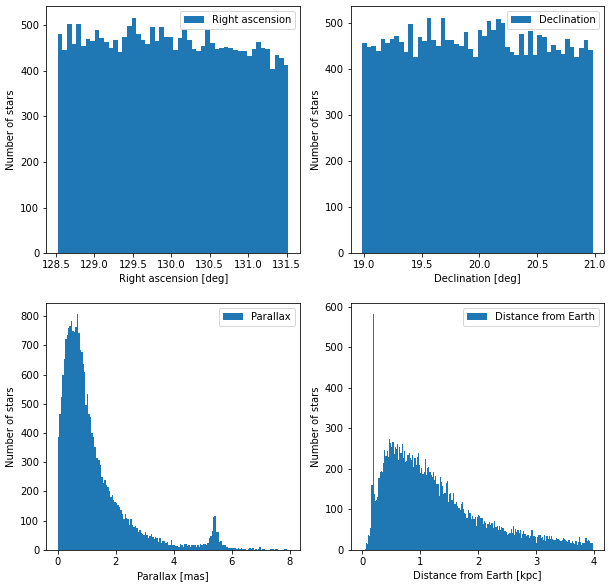

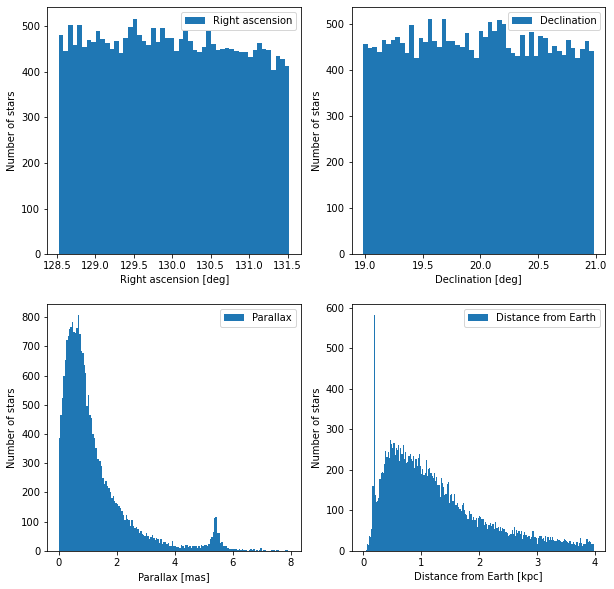

In [75]:
col1 = 'ra'
col2 = 'dec'
col3 = 'parallax'
col4 = 'distance'

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))   # We can select ncols, nrows, or both.

ax[0,0].hist(data1[col1], bins=50, label=data1[col1].description)
ax[0,1].hist(data1[col2], bins=50, label=data1[col2].description)
ax[1,0].hist(data1[col3], bins=np.arange(0, 8, 0.05), label=data1[col3].description)
ax[1,1].hist(data1[col4], bins=np.arange(0, 4, 0.02), label=data1[col4].description)


ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

description1 = data1[col1].description
unit1 = data1[col1].unit
description2 = data1[col2].description
unit2 = data1[col2].unit
description3 = data1[col3].description
unit3 = data1[col3].unit
description4 = data1[col4].description
unit4 = data1[col4].unit

ax[0,0].set_xlabel(f"{description1} [{unit1}]")
ax[0,1].set_xlabel(f"{description2} [{unit2}]")
ax[1,0].set_xlabel(f"{description3} [{unit3}]")
ax[1,1].set_xlabel(f"{description4} [{unit4}]")

ax[0,0].set_ylabel('Number of stars')
ax[0,1].set_ylabel('Number of stars')
ax[1,0].set_ylabel('Number of stars')
ax[1,1].set_ylabel('Number of stars');

### 🌪 Exercise
Redo the previous plot show each panel shows both the Total Sample and the Cluster subset.

## Simplify repetitive tasks with loops over axes/columns

In [83]:
col1 = 'parallax'
col2 = 'distance'
cols = [col1, col2]   # We deine a list of columns to plot

for col, axi in zip(cols, ax):
    print(col, axi)

parallax AxesSubplot(0.125,0.125;0.352273x0.755)
distance AxesSubplot(0.547727,0.125;0.352273x0.755)


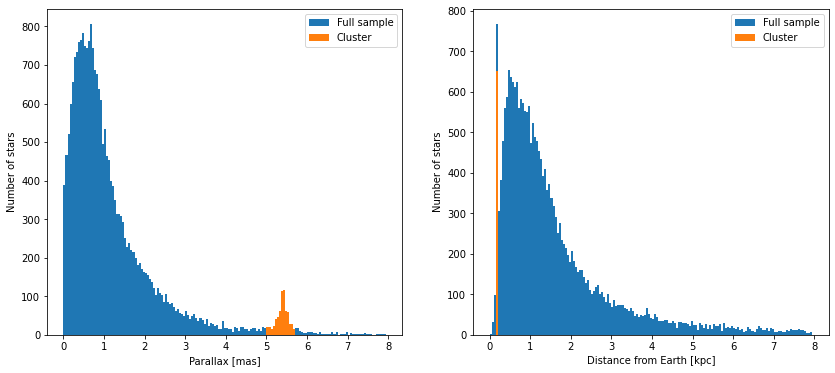

In [84]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))   # This plot will have two panels in a single horizontal row.

for col, axi in zip(cols, ax):
    axi.hist(data1[col],    bins=np.arange(0, 8, 0.05), label='Full sample')  # This plots the blue histogram
    axi.hist(cluster1[col], bins=np.arange(0, 8, 0.05), label='Cluster')      # This plots the orange histogram
    axi.legend()
    
    description = data1[col].description
    unit = data1[col].unit

    axi.set_xlabel(f"{description} [{unit}]")
    axi.set_ylabel('Number of stars')

## Function to make simple plots. The `**kwargs` trick

We can simplify the process even more the process by writting a function that does the repetitive syntax by itself. To be able to use different properties for each panel (for example symbol colors, sizes, labels, etc) we will use `**kwargs`, which basically translates into "any other variable included when calling the function will be passed along".

This function will create a single `scatter` plot of two variables.

In [85]:
def plot_variables(data, col1, col2, ax, **kwargs):
    
    ax.scatter(data[col1], data[col2], **kwargs)

    description1 = data1[col1].description        # Obtain column 1 description
    unit1 = data1[col1].unit                      # Obtain column 1 units
    description2 = data1[col2].description        # Obtain column 2 description
    unit2 = data1[col2].unit                      # Obtain column 2 units

    ax.set_xlabel(f"{description1} [{unit1}]") # Set the axis label in the form "Variable description [units]"
    ax.set_ylabel(f"{description2} [{unit2}]") # Set the axis label in the form "Variable description [units]"

    ax.legend()
    return ax

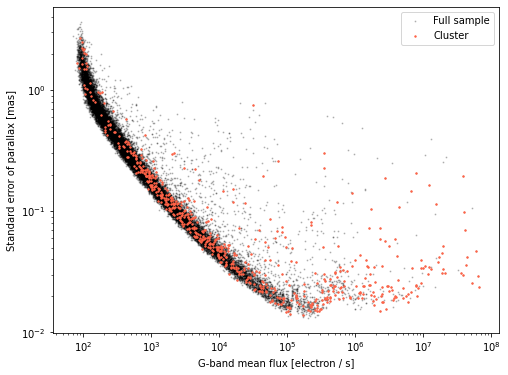

In [86]:
col1 = 'phot_g_mean_flux'
col2 = 'parallax_error'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1,    col1, col2, ax, s=1, c='k',      alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=2, c='tomato', label='Cluster');

ax.loglog();

Now will create a figure with two panels, one for `parallax_error` vs `phot_g_mean_flux`

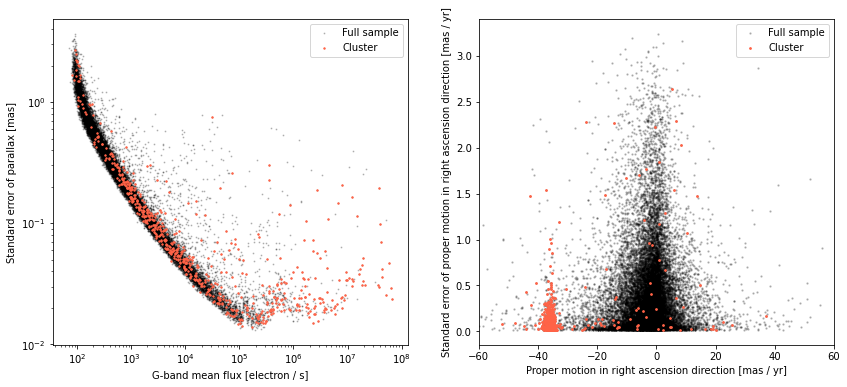

In [91]:
col1 = 'phot_g_mean_flux'
col2 = 'parallax_error'
col3 = 'pmra'
col4 = 'pmra_error'

fig, ax = plt.subplots(ncols=2, figsize=(14,6))   # We can select ncols, nrows, or both.

plot_variables(data1,    col1, col2, ax[0], s=1, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax[0], s=2, c='tomato', label='Cluster')

plot_variables(data1,    col3, col4, ax[1], s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col3, col4, ax[1], s=3, c='tomato', label='Cluster')

# Other options specific to the panel need to be specified individually
ax[0].loglog()
ax[1].set_xlim(-60, 60);

## Velocity distribution analysis
We will try to find some clustering pattern in the velocity space. These are the variables:  

Proper motion in right ascension is $\mu_{\alpha}\cos\delta$  
Proper motion in declination is $\mu_{\delta}$  
Spectroscopic radial velocity in the solar barycentric reference frame is $v_{r}$

### ✨ Exercise 3.4

- Make a plot with a single panel to show the proper motion in declination vs the proper motion in right ascension for the full sample and for the cluster. The full sample table is `data1` and the cluster table is`cluster1`.
- Use different colors for the full samepl and the cluster.
- Use `ax.set_aspect('equal')` so both axes represent the same scales.
- Repeat the plot to zoom with until you see the relevant part of the plot by setting `ax.set_xlim` and `ax.set_ylim` 
- Can you approximately guess the mean proper motion of the cluster?

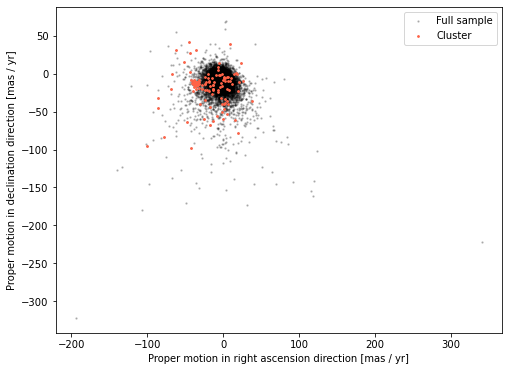

In [93]:
col1 = 'pmra'
col2 = 'pmdec'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1,    col1, col2, ax, s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=3, c='tomato', label='Cluster');

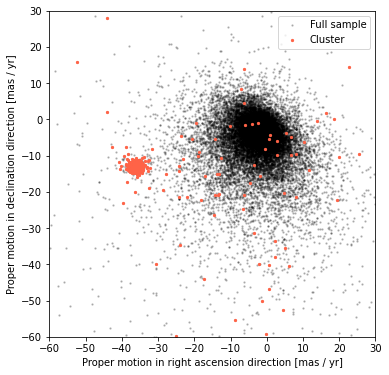

In [94]:
col1 = 'pmra'
col2 = 'pmdec'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1,    col1, col2, ax, s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=5, c='tomato', label='Cluster');

ax.set_aspect('equal')
ax.set_xlim(-60, 30)
ax.set_ylim(-60, 30);

Great, this is much clearer! The cluster is a moving group, where most of the stars have a very similar 2D velocity, even if they are positionally scattered in a wide region of the sky of several degrees. This indicates that the cluster of stars, probably very young, was formed at a similar time from a single gas cloud, so on average they have the same space velocity as the original cloud.

Note that the selection based on distance alone gives a large contamination of stars that don't look like stars from the cluster. A better selection algorithm is needed to avoid those outliers.

### 🌪 Exercise

Repeat the previous plot and include a cross on the average proper motion of the cluster, and the median proper motion of the cluster. Use values from the `cluster1` table to plot the crosses.

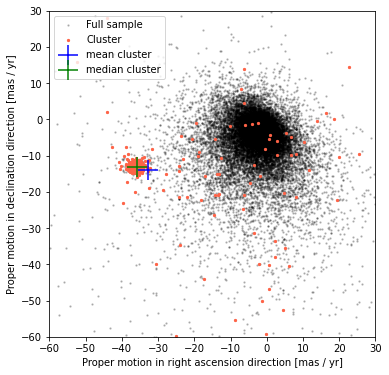

In [95]:
col1 = 'pmra'
col2 = 'pmdec'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1, col1, col2, ax, s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=5, c='tomato', label='Cluster');

ax.scatter(cluster1['pmra'].mean(), cluster1['pmdec'].mean(),
           marker='+', c='b', s = 400, label='mean cluster')
ax.scatter(np.median(cluster1['pmra']), np.median(cluster1['pmdec']),
           marker='+', c='g', s = 400, label='median cluster')

ax.set_aspect('equal')

ax.set_xlim(-60, 30)
ax.set_ylim(-60, 30)

ax.legend();

### 🌪 Exercise

Make a three panel plot to represent. 
- `pmdec` vs `pmra`
- `dr2_radial_velocity` vs `pmra`
- `dr2_radial_velocity` vs `pmdec`
Plot only the full sample and, if you want, also the cluster subset.
- Draw horizontal and vertical lines at the center of the cluster using `axvline` and `axhline`.

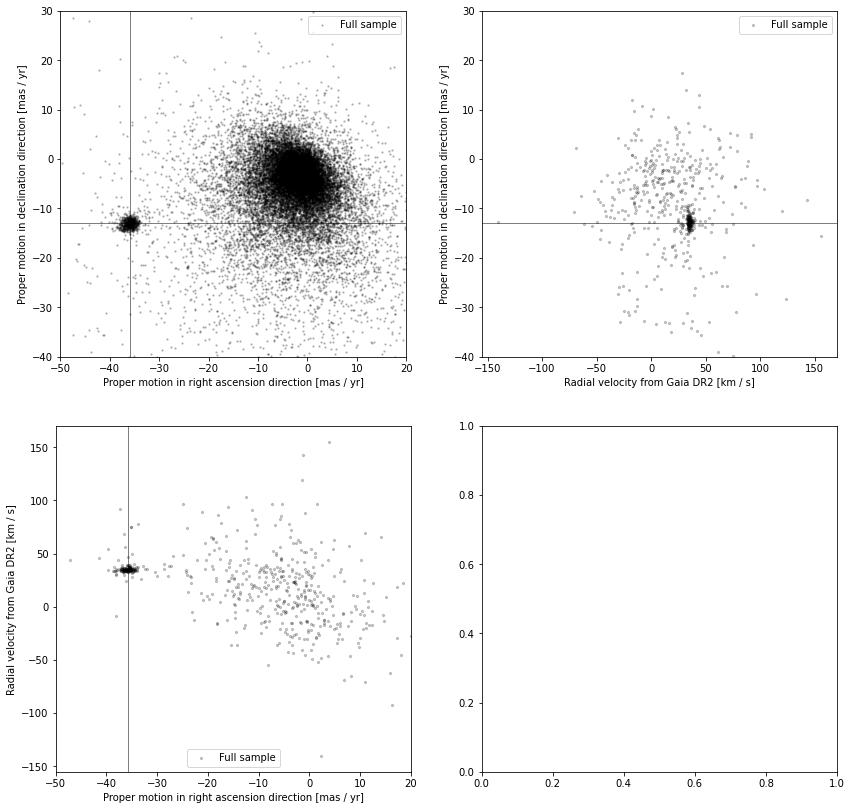

In [124]:
col1 = 'pmra'
col2 = 'pmdec'
col3 = 'dr2_radial_velocity'

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,14))   # We can select ncols, nrows, or both.

plot_variables(data1, col1, col2, ax[0,0], s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(data1, col1, col3, ax[1,0], s=5, c='k', alpha=0.2, label='Full sample')
plot_variables(data1, col3, col2, ax[0,1], s=5, c='k', alpha=0.2, label='Full sample')

ax[0,0].set_aspect('equal')
ax[0,0].set_xlim(-50, 20)
ax[0,0].set_ylim(-40, 30)
ax[1,0].set_xlim(-50, 20)
ax[0,1].set_ylim(-40, 30)

ax[0,0].axvline(np.median(cluster1[col1]), color='k', lw=0.5)
ax[0,0].axhline(np.median(cluster1[col2]), color='k', lw=0.5)
ax[1,0].axvline(np.median(cluster1[col1]), color='k', lw=0.5)
ax[0,1].axhline(np.median(cluster1[col2]), color='k', lw=0.5);

### 🌪 Exercise

- Make a 3 panel plot showing the histograms for `pmra`, `pmdec` and `radial_velocity`
- Include both the full sample and the cluster subset.
- Make sure each panel has an adequate `bins` distribution, and that it is the same for the full and cluster samples. Tip: you can create a list with 3 items, each one being a `np.linespace` object.
- Tip2: for `radial_velocity` select the `bins` that do not select value 0, for example use `np.linspace(1, 60, 50)`.

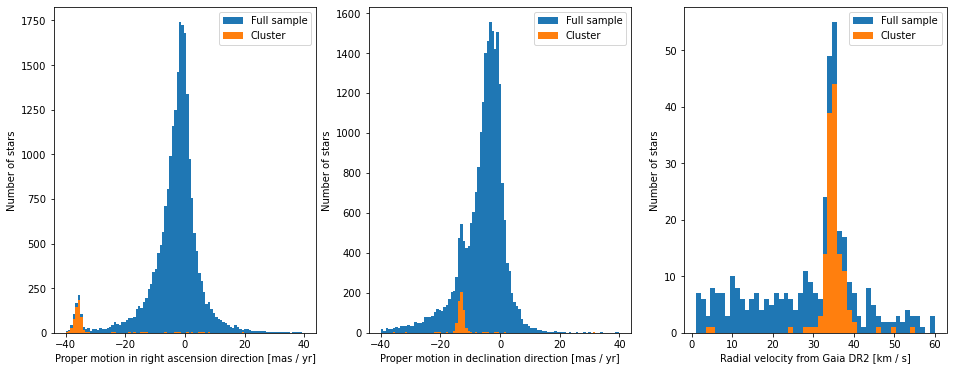

In [129]:
col1 = 'pmra'
col2 = 'pmdec'
col3 = 'dr2_radial_velocity'

cols = [col1, col2, col3]
fig, ax = plt.subplots(ncols=3, figsize=(16,6))   # We can select ncols, nrows, or both.

bins = [
    np.linspace(-40, 40, 100),
    np.linspace(-40, 40, 100),
    np.linspace(1, 60, 50)
]

for col, axi, binsi in zip(cols, ax, bins):
    axi.hist(data1[col], bins=binsi, label='Full sample')
    axi.hist(cluster1[col], bins=binsi, label='Cluster')
    axi.legend()
            
    description = data1[col].description
    unit = data1[col].unit

    axi.set_xlabel(f"{description} [{unit}]")
    axi.set_ylabel('Number of stars')

## Velocity field
Finally, we can plot the velocity field of the stars. Given the large number of stars it is difficult to have a clear picture of the velocity directions and magnitudes of the whole sample. But at least we can see that the great majority of the sample stars have random velocities on all directions while the cluster stars have a predominant 2D direction and sense.

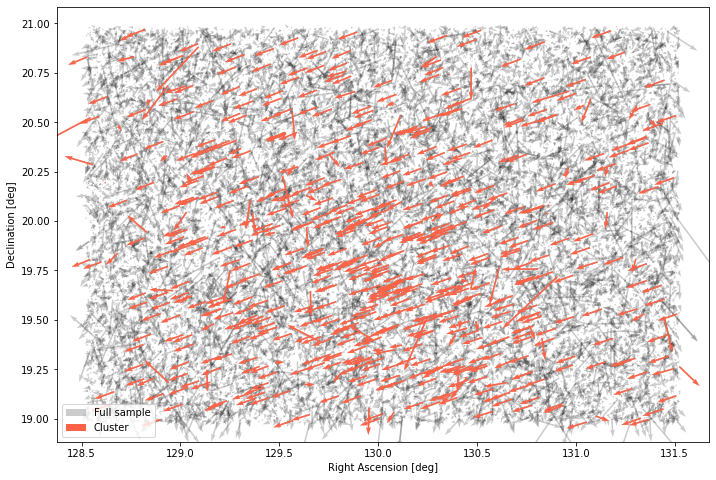

In [237]:
fig, ax = plt.subplots(ncols=1, figsize=(12,8))

ax.quiver(data1['ra'], data1['dec'], data1['pmra'], data1['pmdec'],
          alpha=0.2, scale=1200, label='Full sample');

ax.quiver(cluster1['ra'], cluster1['dec'], cluster1['pmra'], cluster1['pmdec'],
           alpha=1, color='tomato', scale=1200, label='Cluster');
ax.set_aspect('equal')

ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]');

ax.legend();

# Analysis of the cluster kinematics in the Galaxy


`SkyCoord` function is much more powerful than just storing positions. In particular we can include also velocities (both in the plane of the sky and radial), or also cartesian coordinates. Let's start by simply adding the proper motions. 

In [205]:
data1_coord = SkyCoord(ra  = data1['ra'],
                       dec = data1['dec'],
                       pm_ra_cosdec = data1['pmra'],
                       pm_dec = data1['pmdec'],
                       frame = 'icrs')

data1_galactic = data1_coord.galactic

cluster1_coord = SkyCoord(ra  = cluster1['ra'],
                          dec = cluster1['dec'],
                          pm_ra_cosdec = cluster1['pmra'],
                          pm_dec = cluster1['pmdec'],
                          frame = 'icrs')
cluster1_galactic = cluster1_coord.galactic

In [143]:
cluster1_galactic[0:5]

<SkyCoord (Galactic): (l, b) in deg
    [(205.51167177, 32.5370892 ), (205.56054508, 32.54301322),
     (205.54094555, 32.5653027 ), (205.47365865, 32.51819019),
     (205.4784159 , 32.49039104)]
 (pm_l_cosb, pm_b) in mas / yr
    [(-0.95210663, -37.6129466 ), ( 0.56276132, -37.63979887),
     (-0.50852036, -37.53785103), ( 2.77462833, -39.01933124),
     ( 0.19019585, -38.47171441)]>

Now we are going to repeat the three basic plots (position, velocities and quiver plot) but using galactic coordinates.

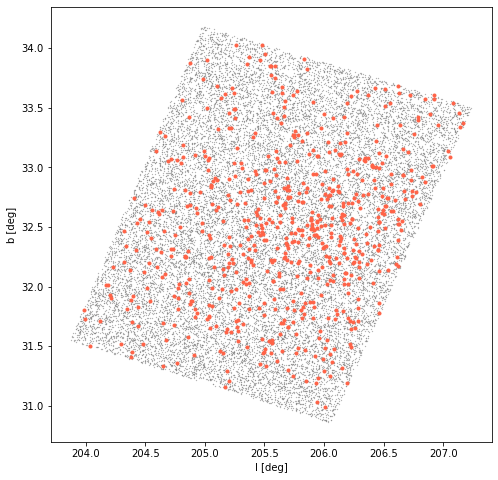

In [207]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(data1_galactic.l,
        data1_galactic.b,
        color='grey', marker='.', ms=0.5, ls='')

ax.plot(cluster1_galactic.l,
        cluster1_galactic.b,
        color='tomato', marker='.', ls='')

ax.set_aspect('equal')

ax.set_xlabel('l [deg]')
ax.set_ylabel('b [deg]');

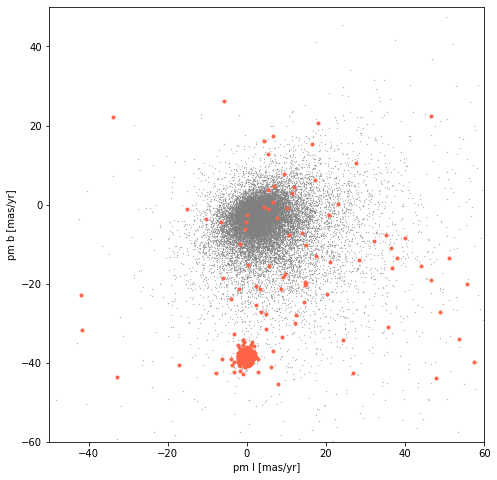

In [208]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(data1_galactic.pm_l_cosb,
        data1_galactic.pm_b,
        color='grey', marker='.', ms=0.5, ls='')

ax.plot(cluster1_galactic.pm_l_cosb,
        cluster1_galactic.pm_b,
        color='tomato', marker='.', ls='')

ax.set_xlim(-50, 60)
ax.set_ylim(-60, 50)
ax.set_aspect('equal')

ax.set_xlabel('pm l [mas/yr]')
ax.set_ylabel('pm b [mas/yr]');

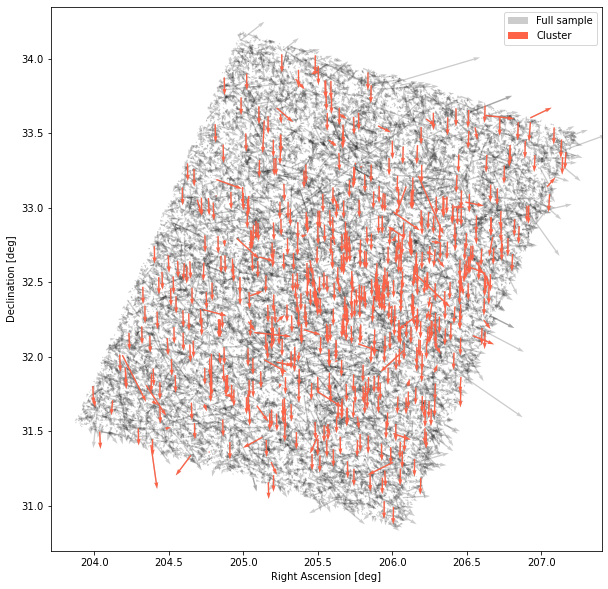

In [238]:
fig, ax = plt.subplots(ncols=1, figsize=(15,10))

ax.quiver(data1_galactic.l.value, data1_galactic.b.value,
          data1_galactic.pm_l_cosb.value, data1_galactic.pm_b.value,
          alpha=0.2, scale=1200, label='Full sample');

ax.quiver(cluster1_galactic.l.value, cluster1_galactic.b.value,
          cluster1_galactic.pm_l_cosb.value, cluster1_galactic.pm_b.value,
           alpha=1, color='tomato', scale=1200, label='Cluster');
ax.set_aspect('equal')


ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]');

ax.legend();

## Galactocentric coordinates

We will now use the full functionality of `SkyCoord` to make 3D transformations. Here we are including the radial velocity, which we now many stars are missing, so we will just focus on average values.

The description of the Galactocentric reference frame in astropy can be found [here](https://docs.astropy.org/en/stable/api/astropy.coordinates.Galactocentric.html).


In [227]:
from astropy.coordinates import Galactocentric

We compute median values as a representative position and movement of the cluster.

In [228]:
ra_median    = np.median(cluster1['ra'])*cluster1['ra'].unit
dec_median   = np.median(cluster1['dec'])*cluster1['dec'].unit
pmra_median  = np.median(cluster1['pmra'])*cluster1['pmra'].unit
pmdec_median = np.median(cluster1['pmdec'])*cluster1['pmdec'].unit
radial_velocity_median = np.median(cluster1['dr2_radial_velocity'].compressed())*cluster1['dr2_radial_velocity'].unit
distance_median = np.median(cluster1['parallax'].to(u.pc, u.parallax())) # We could also have used the "distance" column directly.

Now, we construct the average full-coordinate object.

In [229]:
cluster1_3d = SkyCoord(ra  = ra_median,
                           dec = dec_median,
                           pm_ra_cosdec    = pmra_median,
                           pm_dec          = pmdec_median,
                           radial_velocity = radial_velocity_median,
                           distance        = distance_median,
                           frame = 'icrs')

Finally, we transform the 3D coordinates to the Galactocentric reference frame.

In [230]:
cluster1_galactocentric = cluster1_3d.transform_to(Galactocentric)
cluster1_galactocentric

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in pc
    (-8262.61107683, -67.97824404, 120.75266758)
 (v_x, v_y, v_z) in km / s
    (-29.85956077, 225.09767324, -1.6357255)>

Tip: you can set your own values of the Galactic Centre distance and the Sun 3D velocity, see example in [Transforming positions and velocities to and from a Galactocentric frame](https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py)

### ✨ Exercise 3.5
- Find the Vizier catalog associated with this publication: [Open cluster kinematics with Gaia DR2](https://www.aanda.org/articles/aa/full_html/2018/11/aa34020-18/aa34020-18.html). (Tip: Search in that page the button "Tables at CDS", you will see the catalog code at the top of the page). 
- Download the first table of the catalog and call it `soubiran18` using the function `Vizier.get_catalogs()`.
- Print the first few rows of the table to see what is the name of the columns for Right Ascension and Declination.
- Construct the full coordinates of the clusters in the catalog with:
```python
soubiran18_coord = SkyCoord(ra=soubiran18['RA_ICRS'],
                            dec=soubiran18['DE_ICRS'],
                            frame='icrs')
```
- Calculate the separation between `cluster1_3d` and the coordinates in Soubiran et al. 2018, in degrees. Store it in the variable `separations`.
- Find which item in the catalog is the closest to the center of `cluster1`. You can find the row index with the function `np.argmin` (If you need, run `np.argmin?` to know more about it).
```python
idx_min = np.argmin(separations)
```
- Print item `soubiran18[idx_min]` and explore the table:
  - What is the NGC name of our cluster?
  - Compare our values to the values in the catalog (VR, X, Y, Z, vZ, etc) with the ones we found in the variable `cluster1_galactocentric`
  
Tip: for the comparison, print these values:
```python
print(cluster1_3d.ra.deg)
print(cluster1_3d.dec.deg)
print(cluster1_3d.distance)
print(cluster1_3d.radial_velocity)
```
and also:
```python
print(cluster1_galactocentric.x)
print(cluster1_galactocentric.y)
print(cluster1_galactocentric.z)
print(cluster1_galactocentric.v_z)
```

In [175]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

In [176]:
soubiran18 = Vizier.get_catalogs('J/A+A/619/A155')[0]
soubiran18[0:3]

ID,ID2,RA_ICRS,DE_ICRS,dmode,Nmemb,Nsele,RV,e_RV,s_RV,X,e_X,Y,e_Y,Z,e_Z,U,e_U,V,e_V,W,e_W,Vr,e_Vr,Vphi,e_Vphi,Vz,e_Vz,SimbadName
,,deg,deg,pc,,,km / s,km / s,km / s,pc,pc,pc,pc,pc,pc,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,
str20,str20,float32,float32,float32,int16,int16,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str21
ASCC_10,[KPS2012] MWSC 0275,51.870,34.981,672.0,4,2,-15.67,1.16,1.63,-8923.4,5.1,263.1,2.3,-191.1,1.8,16.27,1.01,-5.24,0.46,-1.67,0.36,-20.08,1.02,247.70,0.43,5.58,0.36,[KPS2012] MWSC 0275
ASCC_101,[KPS2012] MWSC 3070,288.399,36.369,397.3,17,15,-20.17,0.92,3.56,-8194.4,0.5,360.9,1.1,93.9,0.3,-10.08,0.34,-17.12,0.84,-4.60,0.19,9.33,0.31,234.94,0.85,2.65,0.19,[KPS2012] MWSC 3070
ASCC_105,[KPS2012] MWSC 3157,295.548,27.366,551.8,24,20,-13.81,0.50,2.23,-8088.1,0.8,490.6,1.6,33.9,0.1,-4.59,0.23,-12.93,0.45,-5.94,0.06,7.99,0.21,239.26,0.46,1.31,0.06,[KPS2012] MWSC 3157


In [182]:
soubiran18_coord = SkyCoord(ra=soubiran18['RA_ICRS'],
                            dec=soubiran18['DE_ICRS'],
                            frame='icrs')
soubiran18_coord[0:3]

<SkyCoord (ICRS): (ra, dec) in deg
    [( 51.87 , 34.981), (288.399, 36.369), (295.548, 27.366)]>

In [181]:
separations = cluster1_galacitc_3d.separation(soubiran18_coord).deg
separations[0:3]

array([ 69.38411, 120.22357, 130.79274], dtype=float32)

In [183]:
idx_min = np.argmin(separations)
idx_min

533

In [185]:
soubiran18[idx_min]

ID,ID2,RA_ICRS,DE_ICRS,dmode,Nmemb,Nsele,RV,e_RV,s_RV,X,e_X,Y,e_Y,Z,e_Z,U,e_U,V,e_V,W,e_W,Vr,e_Vr,Vphi,e_Vphi,Vz,e_Vz,SimbadName
,,deg,deg,pc,,,km / s,km / s,km / s,pc,pc,pc,pc,pc,pc,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,
str20,str20,float32,float32,float32,int16,int16,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str21
NGC_2632,[KPS2012] MWSC 1527,130.054,19.621,185.5,191,186,34.72,0.08,1.10,-8480.8,0.1,-68.5,0.1,113.5,0.1,-42.76,0.07,-20.41,0.04,-9.83,0.06,29.79,0.07,232.08,0.04,-2.58,0.06,[KPS2012] MWSC 1527


In [200]:
print(cluster1_3d.ra.deg)
print(cluster1_3d.dec.deg)
print(cluster1_3d.distance)
print(cluster1_3d.radial_velocity)

130.04755306468905
19.795115833804818
185.44687403783414 pc
34.8681640625 km / s


In [204]:
print(cluster1_galactocentric.x)
print(cluster1_galactocentric.y)
print(cluster1_galactocentric.z)
print(cluster1_galactocentric.v_z)

-8262.611076827354 pc
-67.97824403719288 pc
120.75266757653554 pc
-1.635725499480819 km / s
